### Corrective RAG (CRAG)

- Took multiple data sources and complex data sources
- strict  prompting in every node based on desired output
- In this architecutre it will be correcting the infomation from any other data source if retriever, is not able to generate a correct output (in this architecture the external data source is web search)

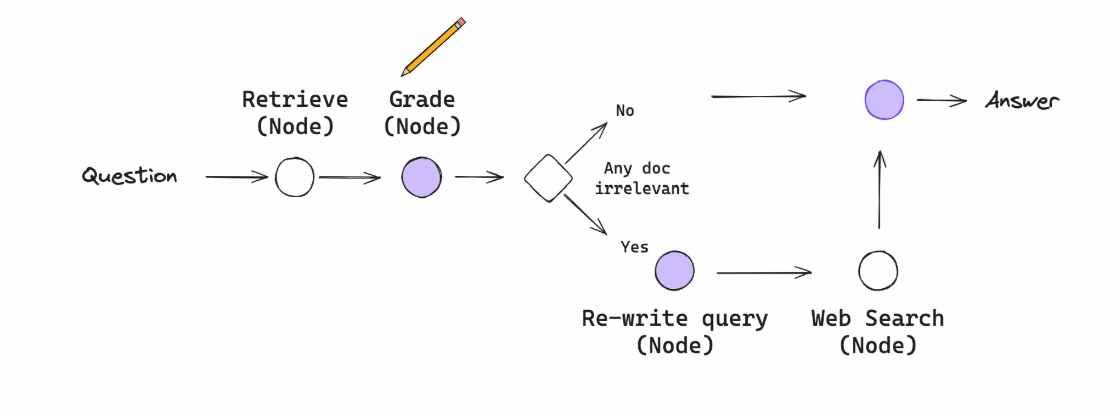

#### Loading required Libraries

In [1]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os

import warnings
warnings.filterwarnings("ignore")

load_dotenv()

True

#### Setting up LLM

In [2]:
llm=ChatGroq(model="llama-3.1-8b-instant")
llm.invoke("Hi, How are you?")

AIMessage(content="I'm doing well, thank you for asking. I'm a large language model, so I don't have emotions or feelings like humans do, but I'm functioning properly and ready to assist you with any questions or tasks you may have. How can I help you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 41, 'total_tokens': 97, 'completion_time': 0.074666667, 'prompt_time': 0.002020807, 'queue_time': 0.19602240099999999, 'total_time': 0.076687474}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'finish_reason': 'stop', 'logprobs': None}, id='run--dfb96547-4bb3-46e9-af11-8e34ade7947f-0', usage_metadata={'input_tokens': 41, 'output_tokens': 56, 'total_tokens': 97})

#### Embedding Model

In [ ]:
from langchain_openai import OpenAIEmbeddings

embeddings=OpenAIEmbeddings(model="text-embedding-3-large")

len(embeddings.embed_query("Hello"))

#### Loading Data

In [ ]:
from langchain_community.document_loaders import WebBaseLoader

In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

In [ ]:
docs=[WebBaseLoader(i).load()[0] for i in urls]
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use 

#### Chuncking the Documents

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100,chunk_overlap=20)

doc_splits=splitter.split_documents(docs)
doc_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use 

#### Setting up VectorStore

In [ ]:
from langchain_community.vectorstores import Chroma
from langchain_core.vectorstores import InMemoryVectorStore

In [ ]:
vectorStore=InMemoryVectorStore.from_documents(documents=doc_splits,embedding=embeddings)

In [ ]:
retriever=vectorStore.as_retriever()
retriever.invoke("what is reward hacking?")


[Document(id='c50f3121-4b9c-4cce-b232-4d87958f2f2a', metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for re

#### Message state setup

In [ ]:
from langchain_core.messages import BaseMessage
from typing import TypedDict,Annotated,Sequence,List
from langgraph.graph import MessagesState,MessageGraph,add_messages,StateGraph,START,END

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    documents:List[str]
    webSearch:str
    answer:str

In [ ]:
def retriever_tool(state:AgentState):

    messages=state["messages"]
    question=messages[-1].content

    result=retriever.invoke(question)

    

    return {"documents":result}

In [ ]:
#retriever_tool({"messages":['agent memory']})

#### Pydantic Data Validation for desired output

In [ ]:

from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain.output_parsers import OutputFixingParser

In [ ]:
class grade(BaseModel):
    grade_score:str=Field(description="Assign Yes, if relavant and No, if not relevant")

In [ ]:
def grader(state:AgentState):

    documents=state["documents"]
    
    messages=state["messages"]
    question=messages[0]
    
    parser = OutputFixingParser.from_llm(
        parser=PydanticOutputParser(pydantic_object=grade),
        llm=llm
    )
    
    format_instructions = parser.get_format_instructions()





    prompt=PromptTemplate( template="""You are a grader assessing relevance of a retrieved document to a user question. 
                            If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                            Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question.

                            Return only "yes" or "no", no explanation. Example: {{ "grade_score": "yes" }}

                            {format_instructions}

                            Question: {question}
                            Document: {document}
                            """,
                                    input_variables=["question", "document"],
                                    partial_variables={"format_instructions": format_instructions}
                                )

    
    chain=prompt | llm | parser
    
    retriver_doc=[]
    webSearch="no"

    for doc in documents:
        score=chain.invoke({"document": doc, "question":question})
        
        if score.grade_score.lower()=="yes":
            retriver_doc.append(doc)
        else:
            webSearch="yes"
    
    state["documents"]=retriver_doc
    state["webSearch"]=webSearch

    

    if webSearch=="yes":
        
        return "rewrite Query"
    else:
        
        return "generate"



    

    

    
    

In [ ]:
grader({
    "messages": ["What is agent memory?"],
    "documents": [
        "Agent memory includes episodic and semantic memory.",
        "The Eiffel Tower is in Paris."
    ],
    "webSearch": "no"
})

KeyError: 'Input to PromptTemplate is missing variables {\'"grade_score"\'}.  Expected: [\'"grade_score"\', \'document\', \'question\'] Received: [\'document\', \'question\']\nNote: if you intended {"grade_score"} to be part of the string and not a variable, please escape it with double curly braces like: \'{{"grade_score"}}\'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT '

In [ ]:
from langchain import hub

In [ ]:
def generate_output(state:AgentState):

    

    messages=state["messages"]
    question=messages[-1]
    context=state["documents"]
    
    prompt=hub.pull("rlm/rag-prompt")

    chain=prompt | llm

    answer=chain.invoke({'context':context,'question':question})



    return {"answer":answer}

    

    





    

In [ ]:
generate_output({'messages': ['Agent memory architecture, how it works and its applications.'],
                 'documents': ['Agent memory includes episodic and semantic memory.', 'Learn how long-term, short-term, and dynamic memory work in AI agents. Train, manage, and optimize your agents for smarter, more accurate conversations. How Machines Remember to Think, Act, and Learn Introduction AI agents—from chatbots to self-driving cars—rely on memory systems to process information, make decisions, and improve over time. Unlike humans, AI agents use short-term memory (STM) and long-term memory (LTM) in specialized ways tailored to computational efficiency. This article explores how these memory systems work, their ... Mem0 offers a robust approach to memory management by extracting key information from past interactions, avoiding duplication, and updating stored information based on recent interactions. Its seamless integration with Azure AI Search and Azure OpenAI simplifies the process, making it easier to manage memory for multiple users and agents. In the context of AI agents, memory is the ability to retain and recall relevant information across time, tasks, and multiple user interactions. It allows agents to remember what happened in the past and use that information to improve behavior in the future. Why Memory Matters in Multi-Agent Systems As artificial intelligence advances, multi-agent systems (MAS) have emerged as a powerful approach for tackling complex, distributed, and large-scale ...'],
                  'webSearch':"yes"})

{'answer': AIMessage(content='Agent memory architecture includes episodic and semantic memory, working as short-term, long-term, and dynamic memory systems to process information and make decisions. It allows agents to retain and recall relevant information across time, tasks, and interactions, enabling them to improve behavior over time. This architecture is applied in AI agents, such as chatbots and self-driving cars, to simplify memory management and optimize performance.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 363, 'total_tokens': 443, 'completion_time': 0.115558658, 'prompt_time': 0.021749768, 'queue_time': 0.215604772, 'total_time': 0.137308426}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'finish_reason': 'stop', 'logprobs': None}, id='run--772915bd-c20c-45f8-a6a3-a6ab6597c8e3-0', usage_metadata={'input_tokens': 363, 'output_tokens': 80, 'total_tokens': 443})}

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [ ]:
def rewrite_query(state:AgentState):

    

    last_message=state["messages"][-1]
    question=last_message

    prompt=PromptTemplate(
        template="""You a question re-writer that converts an input question  to a better version that is optimized 
                    for web search. Look at the input and try to reason about the underlying semantic intent / meaning.
                    ONLY return the rewritten question. No explanation.
                    Input: {question}
                     Rewritten:""",
                    
        input_variables=["question"]  )
    
    chain = prompt | llm | StrOutputParser()

    query=chain.invoke({"question":question})

    return {"messages":[query]}

In [ ]:
rewrite_query({"messages":["agent memory"]})

{'messages': ['"Agent memory management"']}

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import DuckDuckGoSearchResults,DuckDuckGoSearchRun


web_search_tool1=DuckDuckGoSearchResults()
web_search_tool2=DuckDuckGoSearchRun()

In [ ]:
def web_search(state:AgentState):

    last_message=state["messages"][-1].content
    question=last_message
    documents=state["documents"]

    web_result = web_search_tool2.invoke({"query": question})
    documents.append(web_result)
    

    return {"document":documents}


In [ ]:
workflow=StateGraph(AgentState)
workflow.add_node("retriever_tool",retriever_tool)

workflow.add_node("generate_output",generate_output)
workflow.add_node("rewrite_query",rewrite_query)
workflow.add_node("web_search",web_search)

In [ ]:
workflow.add_edge(START,"retriever_tool")


workflow.add_conditional_edges("retriever_tool",
                               grader,
                               {
                                   "rewrite Query":"rewrite_query",
                                   "generate":"generate_output"
                                   
                               })

workflow.add_edge("rewrite_query","web_search")

workflow.add_edge("web_search","generate_output")

workflow.add_edge("generate_output",END)

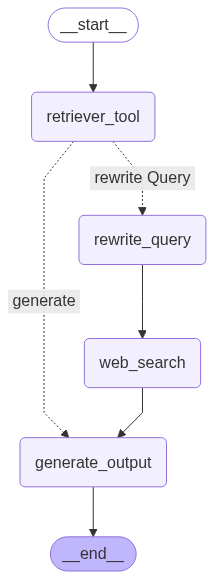

In [ ]:
workflow.compile()

In [ ]:
CRAG=workflow.compile()

In [ ]:
CRAG.invoke({"messages": ["agent memory"]})

grade_score='yes'
grade_score='no'
grade_score='no'


OutputParserException: Failed to parse grade from completion {"grade_score": ["yes"]}. Got: 1 validation error for grade
grade_score
  Input should be a valid string [type=string_type, input_value=['yes'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 

In [ ]:
from pprint import pprint


inputs = {"messages":["agent memory"]}
for output in CRAG.stream(inputs):
    for key, value in output.items():

        print('\n')
        pprint(f"Node : '{key}'")
        print("\n")
        
        pprint(value , indent=2, width=80, depth=None)
    print("\n----------------------------\n")


pprint(value["answer"])

OutputParserException: Failed to parse grade from completion {"grade_score": ["yes"]}. Got: 1 validation error for grade
grade_score
  Input should be a valid string [type=string_type, input_value=['yes'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 